In [1]:
# Standard library imports
import os
import datetime as dt

# Data handling and numerical computations
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import interpolate

# PyTorch related imports
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, kl_divergence
from torch.profiler import profile, record_function, ProfilerActivity
from torchdiffeq import odeint

# Visualization library
import matplotlib.pyplot as plt

# Utilities and custom modules
from itertools import chain
import lib.utils as utils
import lib.models as models
import lib.train_functions as train_functions
import tqdm

# Setting the number of threads for PyTorch and specifying the device
torch.set_num_threads(1)
# device = 'cpu'  # Uncomment this line if you want to set the device to CPU

In [2]:
root = '../google_queries/'

In [3]:
# MISSING VI and PR

In [112]:
sc = 'RI'
df = pd.read_csv('../google_queries/state_queries_new/'+sc+'_query_data.csv', index_col = 0, parse_dates = True)
df = df.reindex(pd.date_range(dt.date(2004,1,8), dt.date(2023,6,27)))
df.to_csv('../google_queries/state_queries_new/'+sc+'_query_data.csv')
percent_complete = int(100000*(1 - pd.isna(df).sum().sum() / np.product(df.shape)))/1000
print(df)

                     flu  flu influenza     flu swine  flu h1n1  \
2004-01-08  64815.796100       0.000000  56993.039426       0.0   
2004-01-09  56716.383915       0.000000      0.000000       0.0   
2004-01-10      0.000000       0.000000      0.000000       0.0   
2004-01-11      0.000000       0.000000      0.000000       0.0   
2004-01-12      0.000000   40672.255501      0.000000       0.0   
...                  ...            ...           ...       ...   
2023-06-23           NaN            NaN           NaN       NaN   
2023-06-24           NaN            NaN           NaN       NaN   
2023-06-25           NaN            NaN           NaN       NaN   
2023-06-26           NaN            NaN           NaN       NaN   
2023-06-27           NaN            NaN           NaN       NaN   

            flu h1n1 swine     avian flu  flu virus  flu swine virus  \
2004-01-08             0.0       0.00000        0.0              0.0   
2004-01-09             0.0   44448.76936        0.0

In [111]:
codes = ['DE', 'MD', 'PA', 'VA', 'WV', 'DC']

state_dict =  {1:['CT', 'ME', 'MT', 'NH', 'RI', 'VT'],
               2:['NY', 'NJ'],
               3:['DE', 'MD', 'PA', 'VA', 'WV', 'DC'],
               4:['AL', 'FL', 'GA', 'KY', 'MS', 'NC', 'SC', 'TN'],
               5:['IL', 'IN', 'OH', 'MI', 'MN', 'WI'],
               6:['AR', 'LA', 'NM', 'OK', 'TX'],
               7:['IA', 'KS', 'MO', 'NE'],
               8:['CO', 'MT', 'ND', 'SD', 'UT', 'WY'],
               9:['AZ', 'CA', 'HI', 'NV'],
              10:['AK', 'ID', 'OR', 'WA']}

for hhs in [1]:
    codes = state_dict[hhs]
    for sc in codes:
        df = pd.read_csv('../google_queries/state_queries_new/'+sc+'_query_data.csv', index_col = 0, parse_dates = True)
        df = df.reindex(pd.date_range(dt.date(2004,1,8), dt.date(2023,6,27)))
        df.to_csv('../google_queries/state_queries_new/'+sc+'_query_data.csv')
        percent_complete = int(100000*(1 - pd.isna(df).sum().sum() / np.product(df.shape)))/1000
        print(df)
        # print(hhs, sc, percent_complete, df.index[0], df.index[-1])

                     flu  flu influenza     flu swine     flu h1n1  \
2004-01-08      0.000000       0.000000      0.000000     0.000000   
2004-01-09      0.000000       0.000000  27056.171461     0.000000   
2004-01-10      0.000000   47391.573831      0.000000     0.000000   
2004-01-11      0.000000       0.000000      0.000000     0.000000   
2004-01-12  12190.190924       0.000000      0.000000     0.000000   
...                  ...            ...           ...          ...   
2023-06-23    746.803883     513.647943      0.000000   371.502948   
2023-06-24    667.701370       0.000000      0.000000     0.000000   
2023-06-25      0.000000       0.000000      0.000000     0.000000   
2023-06-26    964.202436       0.000000      0.000000     0.000000   
2023-06-27      0.000000       0.000000      0.000000  1124.612569   

            flu h1n1 swine   avian flu     flu virus  flu swine virus  \
2004-01-08             0.0    0.000000      0.000000              0.0   
2004-01-09   

In [109]:
def smooth(df, n=7):
    smoothed = pd.DataFrame(index = df.index[n:], 
                            columns = df.columns, 
                            data = np.mean(np.asarray([df[i:-(n-i)] for i in range(n)]), 0))
    return smoothed
    
def get_hhs_query_data(hhs, root = '../google_queries/', append = 'state_queries_new', return_all = False, smooth_after = False):
    state_pop = pd.read_csv(root + 'state_population_data_2019.csv', index_col = 0)
    state_dict =  {1:['CT', 'ME', 'MT', 'NH', 'RI', 'VT'],
                   2:['NY', 'NJ'],
                   3:['DE', 'MD', 'PA', 'VA', 'WV', 'DC'],
                   4:['AL', 'FL', 'GA', 'KY', 'MS', 'NC', 'SC', 'TN'],
                   5:['IL', 'IN', 'OH', 'MI', 'MN', 'WI'],
                   6:['AR', 'LA', 'NM', 'OK', 'TX'],
                   7:['IA', 'KS', 'MO', 'NE'],
                   8:['CO', 'MT', 'ND', 'SD', 'UT', 'WY'],
                   9:['AZ', 'CA', 'HI', 'NV'],
                  10:['AK', 'ID', 'OR', 'WA']}
    
    total_population = sum([state_pop[state_pop['CODE'] == code]['POP'].values[0] for code in state_dict[hhs]])
    
    dfs = []
    for code in state_dict[hhs]:
        population = state_pop[state_pop['CODE'] == code]['POP'].values[0]/total_population
        new_nf = population*pd.read_csv(root+append +'/'+code+'_query_data.csv', index_col=0, parse_dates=True)
        dfs.append(new_nf)
        
    cols = [d.columns for d in dfs]
    common_cols = cols[0]
    for col_list in cols[1:]:
        common_cols = common_cols.intersection(col_list)
    
    idxs = [d.index for d in dfs]
    common_idxs = idxs[0]
    for idx_list in idxs[1:]:    
        common_idxs = common_idxs.intersection(idx_list)
    
    df = pd.DataFrame(index = common_idxs, columns = common_cols, data = 0)
        
    for d in dfs:
        df = df+d.loc[df.index, df.columns]

    if smooth_after:
        df = smooth(df)
        
    if return_all:
        return df, dfs
    return df    

def choose_qs(hhs_df, daily_ili, region, season, n_qs):
    queries = hhs_df[region]
    ili = daily_ili['Region '+str(region)]
    
    index = daily_ili.index.intersection(queries.index)
    queries = queries.loc[index]
    ili = ili.loc[index]
    
    
    dates = pd.date_range(dt.date(season-5, 10, 1), dt.date(season,10,1))
    try:
        corr_df = pd.DataFrame(index=queries.columns,
                     columns=['correlation'],
                     data=[pearsonr(ili.loc[dates].squeeze(), q)[0] for q in
                                   queries.loc[dates].values.T])
    except:
        print(queries)
    scores = pd.read_csv('Data/Similarity_Scores.csv', index_col=0)
    scores['correlation'] = corr_df
    # scores = scores.fillna(0)
    scores = scores.dropna()
    
    for col in scores.columns:
        scores[col] = scores[col] - scores[col].min()
        scores[col] = scores[col] / scores[col].max()
        scores[col] = 1 - scores[col]
    scores['score'] = np.sqrt(np.square(scores).sum(1))
    
    scores = scores.sort_values('score')
    
    query_choice = scores[:n_qs]
    return query_choice.index


def load_ili(location):
    location_dict = {'US':'Data/national_flu.csv',
                     'England':'Data/England_ILIrates.csv',
                     'state':'Data/state_flu.csv',
                     'hhs':'Data/hhs_flu.csv'}
    
    ili = pd.read_csv(location_dict[location], index_col = -1, parse_dates=True)
    if location == 'state' or location =='hhs':
        new_ili = pd.DataFrame()
        for region in ili['region'].unique():
            new_ili[region] = ili[ili['region'] == region]['unweighted_ili']
        ili = new_ili
        ili /= 13
        ili= ili.fillna(0)
        
    if location == 'US':
        ili[['weighted_ili']].rename(columns = {'weighted_ili':'National'})
        ili /= 13
    
    if location == 'England':
        ili['Date'] = [dt.datetime.strptime(d, '%d/%m/%Y')+dt.timedelta(days=3) for d in ili['ISOWeekStartDate'].values]
        ili = ili[['Date', 'RatePer100000']].set_index('Date')
        ili = ili.rename(columns = {'RatePer100000':'National'})


    return ili

def intepolate_ili(ili):
    dates = np.asarray([ili.index[0] + dt.timedelta(days=i) for i in
                    range((ili.index[-1] - ili.index[0]).days + 1)])

    x = np.linspace(0, 1, ili.shape[0])
    x2 = np.linspace(0, 1, dates.shape[0])
    f = interpolate.interp1d(x, ili.values, axis = 0, kind = 'cubic')
    
    daily_ili = pd.DataFrame(index=dates, columns=ili.columns, data=f(x2))
    return daily_ili

In [110]:
ili = load_ili('hhs')
ili = intepolate_ili(ili)

hhs_dict = {}
qs_dict = {}
for i in range(1,1+n_regions):
    hhs_dict[i] = get_hhs_query_data(i, smooth_after = True)
    qs_dict[i] = choose_qs(hhs_dict, ili, i, season, n_qs)

    hhs_dict[i] = hhs_dict[i].loc[:, list(qs_dict[i])]
    hhs_dict[i] = hhs_dict[i].div(hhs_dict[i].max())
    
ili = ili.loc[hhs_dict[i].index[0] : hhs_dict[i].index[-1]]
ili = ili.div(ili.max())

                     flu  flu influenza     flu swine      flu h1n1  \
2004-01-15  17633.675341   11109.913854   8220.699242  18982.285788   
2004-01-16  16476.045639   12733.608381   8288.534435  18647.548144   
2004-01-17  16041.803041   12840.494607   6760.997066  21456.247482   
2004-01-18  18883.321213   10164.861061   8726.625723  20080.103518   
2004-01-19  17945.871050    8713.986165  10737.999543  20207.116686   
...                  ...            ...           ...           ...   
2010-01-11   4520.073976    3405.304980   3615.280934   2009.520448   
2010-01-12   4152.982209    2686.992314   4245.265707   2316.077401   
2010-01-13   3708.438072    2749.128021   4427.558763   2274.574862   
2010-01-14   3446.863143    2749.128021   4409.141779   1929.170676   
2010-01-15   3215.157595    2806.986805   4222.866885   1328.386896   

            flu h1n1 swine     avian flu     flu virus  flu swine virus  \
2004-01-15             0.0  16385.063674  14703.830116              0.0 

UnboundLocalError: local variable 'corr_df' referenced before assignment

In [75]:
season = 2016
n_qs = 5
n_regions = 10
window = 42
gamma = 9*7
lag = 14
batch = 0
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

inputs = []
outputs = []

for batch in range(ili.shape[0] - (window+gamma)):
    batch_inputs = []
    for i in range(1,11):
        batch_inputs.append(hhs_dict[i].iloc[batch:batch+window])
    
    t_ili = ili.iloc[batch:batch+window].copy()
    t_ili.iloc[-lag:, :] = -1
    batch_inputs.append(t_ili)
    batch_inputs = np.concatenate(batch_inputs, -1)
    
    batch_outputs = ili.iloc[batch+window-lag:batch+window-lag+gamma].values
    
    inputs.append(batch_inputs)
    outputs.append(batch_outputs)
inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32)
outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32)

In [76]:
def reparam(eps, std, mean, n_samples, batch_size):
    z = eps * std + mean
    z = torch.concat([torch.abs(z[..., :2]), (1 - torch.abs(z[..., :2]).sum(-1)).unsqueeze(-1), z[..., 2:]], -1)
    z = z.reshape((n_samples * batch_size, ) + z.shape[2:])
    return z

def make_prior(mean, z_prior=torch.tensor([0.1, 0.01]), device='cpu', latent_dim=8):
    z_prior=z_prior.to(device)
    mean_concat = torch.cat((mean[..., :2]  , torch.zeros_like(mean[..., 2:], device=device)), dim=-1)
    std = torch.cat([z_prior[0].unsqueeze(0), z_prior[1].unsqueeze(0), torch.ones(latent_dim - len(z_prior) - 1, device=device)], 0).expand_as(mean_concat)

    return Normal(mean_concat, torch.abs(std))

In [77]:
class Encoder_MISO_GRU(nn.Module):
    def __init__(self, n_regions, input_size=10, latent_dim = 6, q_sizes=[128, 64], ili_sizes=[32, 16], ff_sizes = [64,32], SIR_scaler=[0.1, 0.05, 1.0], device='cpu', dtype=torch.float32):
        super(Encoder_MISO_GRU, self).__init__()

        n_qs = input_size-1
        self.scaler = torch.tensor(SIR_scaler, dtype=dtype, device=device)
        self.latent_dim = latent_dim
        if latent_dim > len(self.scaler):
            extension = self.scaler[-1].repeat(latent_dim - len(self.scaler))
            self.scaler = torch.cat([self.scaler, extension])
        self.scaler = self.scaler.view(1, -1)
        
        self.n_regions = n_regions

        self.i_layers = nn.ModuleList()
        self.i_layers.append(nn.GRU(n_regions, ili_sizes[0], batch_first=True))
        for l in range(1, len(ili_sizes)):
            self.i_layers.append(nn.GRU(ili_sizes[l-1], ili_sizes[l], batch_first=True))

        self.q_layers = nn.ModuleList()
        self.q_layers.append(nn.GRU(n_regions * n_qs, q_sizes[0], bidirectional=True, batch_first=True))
        for l in range(1, len(q_sizes)):
            self.q_layers.append(nn.GRU(2*q_sizes[l-1], q_sizes[l], bidirectional=True, batch_first=True))

        self.ff_layers = nn.ModuleList()
        self.ff_layers.append(nn.Linear(2*q_sizes[-1] + ili_sizes[-1], ff_sizes[0]))
        for l in range(1, len(ff_sizes)):
            self.ff_layers.append(nn.ReLU())
            self.ff_layers.append(nn.Linear(ff_sizes[l-1], ff_sizes[l]))
        self.ff_layers.append(nn.Linear(ff_sizes[l], 2 * n_regions * latent_dim))

    def forward(self, x):
        x_qs = x[:, :, :-self.n_regions]
        x_ili = x[:, :-14, -self.n_regions:]

        for GRU_layer in self.i_layers:
            x_ili, _ = GRU_layer(x_ili)

        for GRU_layer in self.q_layers:
            x_qs, _ = GRU_layer(x_qs)
        x_concat = torch.cat([x_ili[:, -1, :], x_qs[:, -1, :]], -1)

        for ff_layer in self.ff_layers:
            x_concat = ff_layer(x_concat)

        mean, std = utils.split_last_dim(x_concat)
        mean = mean.reshape(-1, self.n_regions, self.latent_dim)
        std = std.reshape(-1, self.n_regions, self.latent_dim)
        std = torch.abs(std) * self.scaler
        return mean, std


In [78]:
print(enc)

Encoder_MISO_GRU(
  (i_layers): ModuleList(
    (0): GRU(10, 32, batch_first=True)
    (1): GRU(32, 16, batch_first=True)
  )
  (q_layers): ModuleList(
    (0): GRU(50, 128, batch_first=True, bidirectional=True)
    (1): GRU(256, 64, batch_first=True, bidirectional=True)
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=144, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=80, bias=True)
  )
)


In [79]:
n_regions = 10
latent_dim = 6
batch_size = 32
layer_sizes=[50, 50]
n_hidden = 50
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

latent_dim=5
# enc = Encoder_BiDirectionalGRU(input_size=6, layer_sizes=layer_sizes, n_hidden=n_hidden, latent_dim=latent_dim-1, n_regions = n_regions, device=device)
enc = Encoder_MISO_GRU(input_size=6, latent_dim=latent_dim-1, n_regions = n_regions, device=device)

ode = models.Fp(n_regions, latent_dim, nhidden=64)
dec = models.Decoder(n_regions, 3, 1, device=device)

enc.to(device)
ode.to(device)
dec.to(device)
print('')

num = np.sum([np.prod(_.shape) for _ in list(enc.parameters())])
print('encoder parameters:', num)

num = np.sum([np.prod(_.shape) for _ in list(ode.parameters())])
print('ode parameters:', num)

num = np.sum([np.prod(_.shape) for _ in list(dec.parameters())])
print('decoder parameters:', num)


encoder parameters: 282512
ode parameters: 8724
decoder parameters: 310


In [80]:
batch_size = 32
new_inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32).to(device)
new_outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32).to(device)

train_size = len(new_inputs) - 365
x_tr, y_tr = new_inputs[:train_size], new_outputs[:train_size]
x_test, y_test = new_inputs[train_size:], new_outputs[train_size:]

# batch it all 
x_train = []
y_train = []
for b in range(int(np.ceil(x_tr.shape[0]/batch_size))):
    x_train.append(torch.tensor(x_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))
    y_train.append(torch.tensor(y_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))

/tmp/ipykernel_1654984/2700302144.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train.append(torch.tensor(x_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))
/tmp/ipykernel_1654984/2700302144.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train.append(torch.tensor(y_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))


In [81]:
enc.i_layers[0](x_train[0][..., -10:])
enc.q_layers[0](x_train[0][..., :-10])
enc(x_train[-1])[0].min()

tensor(-0.2166, grad_fn=<MinBackward1>)

In [82]:
lr = 1e-3
means=[0.8, 0.55]
stds = [0.2, 0.2]
optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()

In [49]:
optimizer = torch.optim.Adam(enc.parameters(), lr=lr)
for epoch in range(3):
    kls = 0
    pbar = tqdm.tqdm(x_train)
    num = 0
    for x_tr in pbar:
        optimizer.zero_grad()
        
        mean, std = enc(x_tr)
        prior = make_prior(mean, latent_dim=latent_dim, device=device)
        kl = kl_divergence(Normal(mean, std), prior).mean(0).sum()
        if torch.isnan(kl):
            break
        kl.backward()
        optimizer.step()
        kls += kl.cpu().detach().numpy()
        num += 1
        pbar.set_postfix({'Epoch':epoch, 'KL_z':kls/num})

100%|██████████| 169/169 [00:10<00:00, 16.65it/s, Epoch=2, KL_z=0.117]


In [83]:
root = 'checkpoints/HHS_SIR_Big/'   
enc.load_state_dict(torch.load(root+'enc_' + '.pth'))
ode.load_state_dict(torch.load(root+'sir_' + '.pth'))
dec.load_state_dict(torch.load(root+'dec_' + '.pth'))

<All keys matched successfully>

In [84]:
lr = 1.0e-3
means=[0.8, 0.55]
stds = [0.2, 0.2]
optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()

In [ ]:
dtype=torch.float32
torch.cuda.empty_cache()

n_samples = 128
epochs = 1000
root = 'checkpoints/HHS_SIR_Big_new/'      
tmax = 8

for epoch in range(epochs):
    # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        t = torch.linspace(0,tmax-1, tmax, device=device)
        eval_pts = [0,6,13,20,27,34,40,47,54,][:tmax]
    
        pbar = tqdm.tqdm(zip(x_train, y_train))
        for x_tr, y_tr in pbar:
            batch_size = x_tr.shape[0]
            eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
            ode.clear_tracking()
            optimizer.zero_grad()
            
            mean, std = enc(x_tr)
            z = reparam(eps, std, mean, n_samples, batch_size)
            latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
            y_pred = dec(latent[..., :3]).reshape((-1, n_samples, batch_size, n_regions)).permute(2,1,0,3)
    
            nll = train_functions.nll_loss(y_pred, y_tr[:, eval_pts, :])
            
            kl_p = train_functions.get_kl_params(1, ode.posterior(), means=means, stds = stds,limit = 1e6, device=device)
            kl_z = kl_divergence(make_prior(mean, latent_dim=latent_dim, device=device), Normal(mean, std)).sum(-1).mean() / len(x_train)
            reg_loss = train_functions.latent_init_loss(latent[..., :3])
    
            loss = nll+0.1*kl_p+kl_z+reg_loss
            loss.backward()
            optimizer.step()
            _history.batch([loss.cpu(), nll.cpu(), kl_z.cpu(),kl_p.cpu(),reg_loss.cpu(), optimizer.param_groups[-1]['lr']], ['loss', 'nll', 'kl_latent', 'kl_params', 'reg_loss', 'lr'])
            pbar.set_postfix(_history.epoch())
        _history.reset()
        if epoch > 10:
            if np.all([h['nll'] < -2 for h in _history.epoch_history[-10:]]):
                tmax = min(tmax+1, 9)
            
        utils.update_learning_rate(optimizer, 0.999, lr/10)

        if not os.path.exists(root):
            os.mkdir(root)
        torch.save(enc.state_dict(), root+'enc_' + '.pth')
        torch.save(ode.state_dict(), root+'sir_' + '.pth')
        torch.save(dec.state_dict(), root+'dec_' + '.pth')
    
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    # prof.export_chrome_trace(f"trace_epoch_{epoch}.json")
    
    

168it [02:21,  1.19it/s, loss=-1.29, nll=-1.33, kl_latent=0.0162, kl_params=0.219, reg_loss=0.00485, lr=0.000996]
168it [02:13,  1.25it/s, loss=-1.33, nll=-1.37, kl_latent=0.0152, kl_params=0.19, reg_loss=0.00903, lr=0.000995] 
168it [02:17,  1.22it/s, loss=-1.35, nll=-1.38, kl_latent=0.0152, kl_params=0.177, reg_loss=0.000899, lr=0.000994]
168it [02:20,  1.19it/s, loss=-1.36, nll=-1.39, kl_latent=0.015, kl_params=0.165, reg_loss=0.00244, lr=0.000993] 
168it [02:19,  1.20it/s, loss=-1.37, nll=-1.4, kl_latent=0.0146, kl_params=0.156, reg_loss=0.00118, lr=0.000992] 
168it [02:21,  1.19it/s, loss=-1.37, nll=-1.4, kl_latent=0.0143, kl_params=0.148, reg_loss=0.00295, lr=0.000991] 
168it [02:19,  1.20it/s, loss=-1.37, nll=-1.4, kl_latent=0.0143, kl_params=0.143, reg_loss=0.00199, lr=0.00099] 
168it [02:20,  1.20it/s, loss=-1.38, nll=-1.41, kl_latent=0.0139, kl_params=0.137, reg_loss=0.00332, lr=0.000989]
168it [02:20,  1.19it/s, loss=-1.39, nll=-1.42, kl_latent=0.0131, kl_params=0.131, reg_l

In [52]:
enc.load_state_dict(torch.load(root+'enc_' + '.pth'))
ode.load_state_dict(torch.load(root+'sir_' + '.pth'))
dec.load_state_dict(torch.load(root+'dec_' + '.pth'))

<All keys matched successfully>

(-2.0, 1.0)

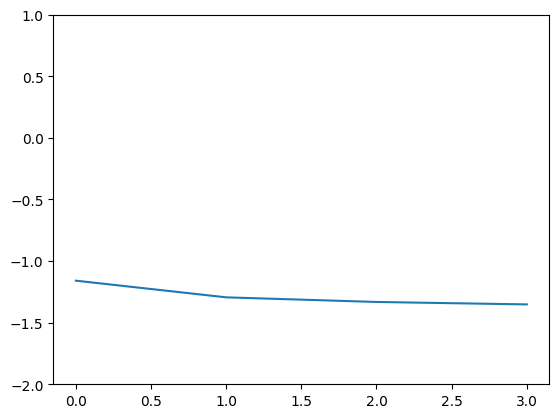

In [86]:
plt.plot([h['nll'] for h in _history.epoch_history])
plt.ylim([-2, 1])

In [90]:
x_in = x_test
y_in = y_test

n_samples = 128
dtype=torch.float32

t = torch.linspace(0,tmax-1, tmax, device=device)
eval_pts = [0,6,13,20,27,34,40,47,54,][:tmax]

batch_size = x_in.shape[0]
eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
ode.clear_tracking()

optimizer.zero_grad()


mean, std = enc(x_in)

z = reparam(eps, std, mean, n_samples, batch_size)
latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
y_pred = dec(latent[..., :3]).reshape((tmax, n_samples, batch_size, n_regions)).permute(2,1,0,3)

mean = y_pred.mean(1)
std = y_pred.std(1)

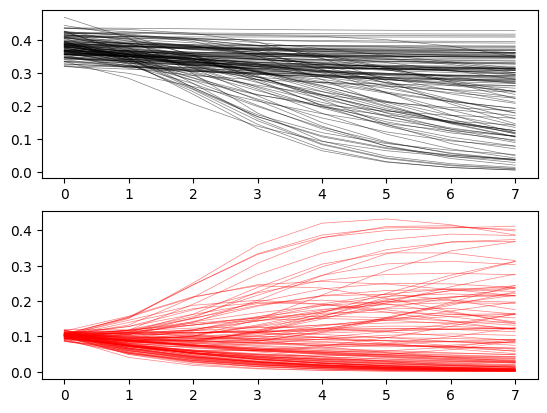

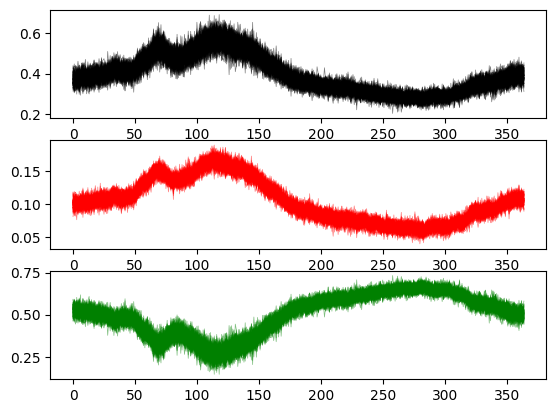

In [92]:
L = latent.reshape((tmax, n_samples, batch_size, n_regions, latent_dim)).detach()

for i in range(n_samples):
    plt.subplot(2,1,1)
    plt.plot(L[:, i, 10, 0, 0], color='black', linewidth = 0.5, alpha =0.5)
    plt.subplot(2,1,2)
    plt.plot(L[:, i, 10, 0, 1], color='red', linewidth = 0.5, alpha =0.5)
plt.show()

for i in range(n_samples):
    plt.subplot(3,1,1)
    plt.plot(L[0, i, :, 0, 0], color='black', linewidth = 0.5, alpha =0.5)
    plt.subplot(3,1,2)
    plt.plot(L[0, i, :, 0, 1], color='red', linewidth = 0.5, alpha =0.5)
    plt.subplot(3,1,3)
    plt.plot(L[0, i, :, 0, 2], color='green', linewidth = 0.5, alpha =0.5)
plt.show()

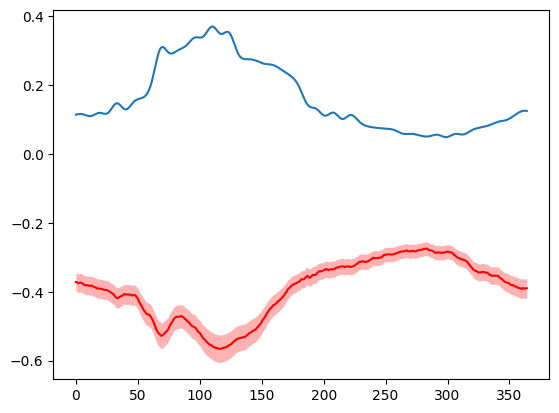

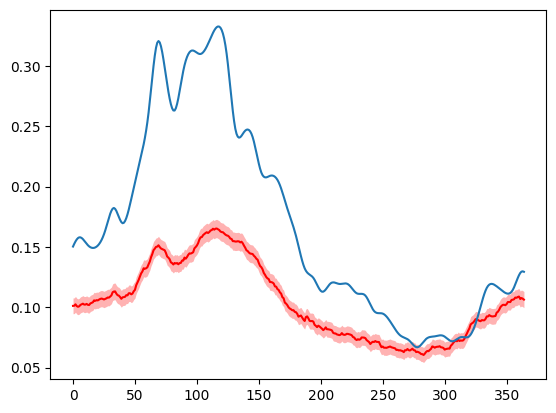

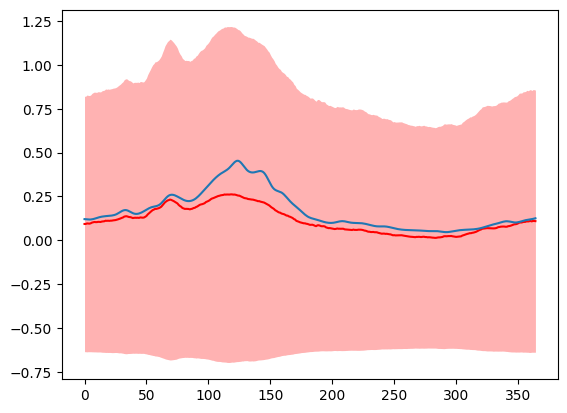

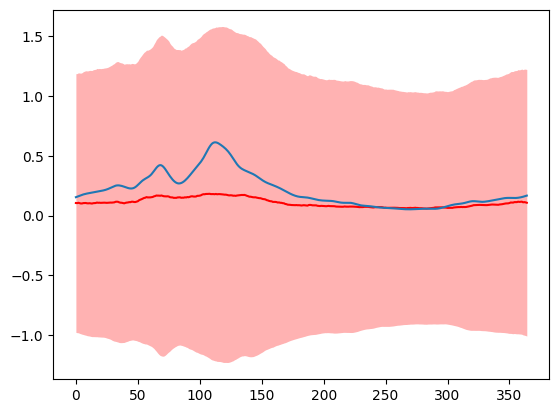

IndexError: index 4 is out of bounds for dimension 2 with size 4

In [88]:
g = 0

for hhs in range(10):

    plt.plot(mean[:, g, hhs].cpu().detach(), color='red')
    plt.plot(y_in[:, g, hhs].cpu().detach())
    
    plt.fill_between(np.linspace(0, mean.shape[0]-1, mean.shape[0]), 
                     (std+mean)[:, g, hhs].cpu().detach(), 
                     (mean-std)[:, g, hhs].cpu().detach(), color='red', alpha=0.3, linewidth=0)
    plt.show()

In [ ]:
x_test.shape